## Credit Card Default — Error Analysis & Reliability

This notebook examines misclassified predictions from the trained models
to understand where and why errors occur, and to assess the reliability
of default risk predictions.


## Importing Libraries and loading the dataset

In [1]:
import pandas as pd    
import numpy as np
import joblib          
import matplotlib.pyplot as plt             
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

cd = pd.read_csv("../data/credit_default.csv")
cd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Separating Features and Target variables

In [2]:
X = cd.drop(columns=['ID', 'default.payment.next.month'])
y = cd['default.payment.next.month'].astype(int)

print(f"Dataset Shape: {cd.shape}")
print(f"X Shape: {X.shape}, y Shape: {y.shape}")
print(f"Target Distribution:\n{y.value_counts(normalize=True)}")

Dataset Shape: (30000, 25)
X Shape: (30000, 23), y Shape: (30000,)
Target Distribution:
default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


## Applying Train/Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y, shuffle=True)

## Loading Gradient Boosting Model

In [4]:
gbc_model = joblib.load("../models/gbc_model.pkl")

## Generate predictions + probabilities

In [5]:
y_pred = gbc_model.predict(X_test)
y_proba = gbc_model.predict_proba(X_test)[:, 1]  # prob of class 1 (default)

## Confusion Matrix Deep Dive

In [7]:
# Confusion matrix in sklearn is ordered as:
# [[TN, FP],
#  [FN, TP]]
gbc_model_cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = gbc_model_cm.ravel()

print("Confusion Matrix:\n", gbc_model_cm)
print(f"TN (True Negatives):  {tn}")
print(f"FP (False Positives): {fp}")
print(f"FN (False Negatives): {fn}")
print(f"TP (True Positives):  {tp}")

Confusion Matrix:
 [[4429  244]
 [ 846  481]]
TN (True Negatives):  4429
FP (False Positives): 244
FN (False Negatives): 846
TP (True Positives):  481


## Getting Error rates

In [8]:
fnr = fn / (fn + tp)  # missed defaulters rate
fpr = fp / (fp + tn)  # false alarm rate

print(f"False Negative Rate (missed defaulters): {fnr:.3f}")
print(f"False Positive Rate (false alarms):      {fpr:.3f}")

False Negative Rate (missed defaulters): 0.638
False Positive Rate (false alarms):      0.052


- FN is usually the most expensive in credit risk (you approve someone who will default).

- FP is lost opportunity (you reject a good customer).

### False Positives (Over-Flagged Customers)

False positives represent customers predicted to default who actually did not.
While false positives may reduce customer satisfaction, their financial impact is typically lower than that of missed defaults.


In [9]:
# Build comparison DataFrame
results_df = X_test.copy()
results_df["actual"] = y_test.values
results_df["predicted"] = y_pred
results_df["prob_default"] = y_proba

# False Negatives: actual = 1, predicted = 0
false_negatives = results_df[
    (results_df["actual"] == 1) &
    (results_df["predicted"] == 0)
]

# True Positives: actual = 1, predicted = 1
true_positives = results_df[
    (results_df["actual"] == 1) &
    (results_df["predicted"] == 1)
]

print("False Negatives shape:", false_negatives.shape)
print("True Positives shape:", true_positives.shape)

False Negatives shape: (846, 26)
True Positives shape: (481, 26)


In [11]:
fn_summary = false_negatives.describe().T
tp_summary = true_positives.describe().T

comparison = fn_summary[["mean"]].join(tp_summary[["mean"]], lsuffix="_FN", rsuffix="_TP")

comparison.sort_values("mean_FN", ascending=False).head(10)


,mean_FN,mean_TP
LIMIT_BAL,155269.125296,106465.696466
BILL_AMT1,42474.697400,65109.014553
BILL_AMT2,41484.359338,64881.640333
BILL_AMT3,39688.089835,62193.449064
BILL_AMT4,35642.731678,59130.883576
BILL_AMT5,32910.615839,56501.871102
BILL_AMT6,31844.970449,55153.353430
PAY_AMT2,3765.037825,2524.395010
PAY_AMT1,3609.777778,3008.268191
PAY_AMT6,3405.131206,3461.864865


- False negatives tend to have higher credit limits and lower outstanding balances compared to correctly identified defaulters. This indicates that the model relies heavily on recent financial strength, leading to underestimation of risk for customers whose historical behavior appears stable. These observations suggest that lowering the classification threshold could significantly reduce missed defaults without major structural model changes.

### False Positives (Over-Flagged Customers)

False positives represent customers predicted to default who actually did not.
While false positives may reduce customer satisfaction, their financial impact is typically lower than that of missed defaults.


In [12]:
# False Positives: actual = 0, predicted = 1
false_positives = results_df[
    (results_df["actual"] == 0) &
    (results_df["predicted"] == 1)
]

# True Negatives: actual = 0, predicted = 0
true_negatives = results_df[
    (results_df["actual"] == 0) &
    (results_df["predicted"] == 0)
]

print("False Positives shape:", false_positives.shape)
print("True Negatives shape:", true_negatives.shape)


False Positives shape: (244, 26)
True Negatives shape: (4429, 26)


In [13]:
fp_summary = false_positives.describe().T
tn_summary = true_negatives.describe().T

comparison_fp = fp_summary[["mean"]] \
    .join(tn_summary[["mean"]], lsuffix="_FP", rsuffix="_TN")

comparison_fp.sort_values("mean_FP", ascending=False).head(10)


,mean_FP,mean_TN
LIMIT_BAL,99672.131148,180828.629487
BILL_AMT1,60400.926230,51546.402574
BILL_AMT2,58216.770492,49349.538045
BILL_AMT3,55282.856557,47127.869045
BILL_AMT4,50992.520492,43145.340483
BILL_AMT5,47501.713115,40367.109280
BILL_AMT6,47479.209016,39032.458794
PAY_AMT6,4755.065574,5699.076767
PAY_AMT5,4717.094262,5515.291488
PAY_AMT4,4606.504098,5618.266877


- False positives exhibit characteristics associated with elevated short-term risk, including lower credit limits, higher outstanding balances, and reduced recent payments compared to true negatives. Although these customers did not ultimately default, the model’s conservative behavior is driven by meaningful financial indicators rather than noise. This suggests that the trade-off between false positives and false negatives is primarily governed by the classification threshold rather than model instability.

## Probability Confidence Analysis

In [14]:
# Correct vs incorrect predictions
correct_mask = (y_test == y_pred)
incorrect_mask = (y_test != y_pred)

correct_probs = y_proba[correct_mask]
incorrect_probs = y_proba[incorrect_mask]

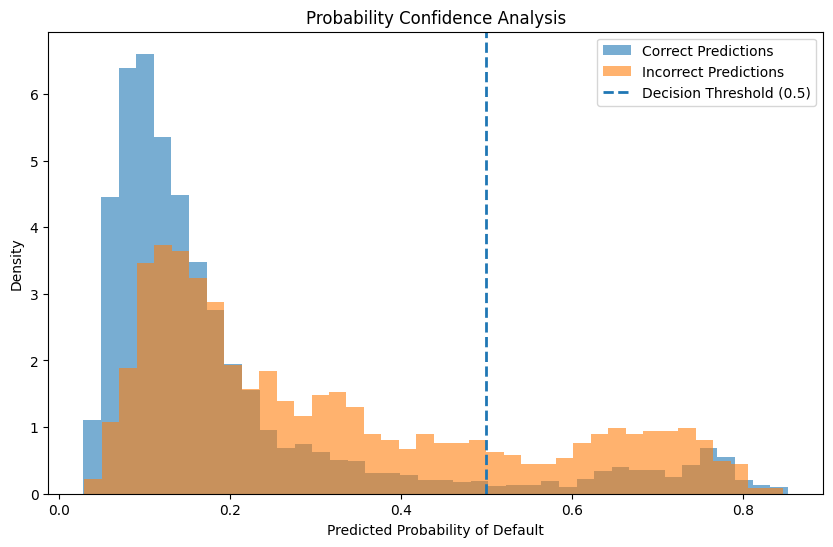

In [15]:
plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs,
    bins=40,
    alpha=0.6,
    label="Correct Predictions",
    density=True
)

plt.hist(
    incorrect_probs,
    bins=40,
    alpha=0.6,
    label="Incorrect Predictions",
    density=True
)

plt.axvline(
    x=0.5,
    linestyle="--",
    linewidth=2,
    label="Decision Threshold (0.5)"
)

plt.xlabel("Predicted Probability of Default")
plt.ylabel("Density")
plt.title("Probability Confidence Analysis")
plt.legend()
plt.show()


The probability confidence analysis demonstrates that misclassifications are concentrated near the default decision threshold. Correct predictions occur primarily at extreme probability values, indicating that the model expresses uncertainty clearly. This suggests that model performance limitations are driven primarily by threshold selection rather than insufficient feature representation. As a result, adjusting the classification threshold is expected to significantly reduce false negatives with an acceptable increase in false positives.

### Threshold Sensitivity

The default classification threshold of 0.5 represents a neutral decision rule that assumes equal cost for false positives and false negatives. However, in credit risk modeling, this assumption rarely holds in practice.

False negatives customers who are predicted as safe but later default typically result in direct financial loss, whereas false positives mainly lead to opportunity cost and potential customer dissatisfaction. As a result, minimizing false negatives is often more critical than maximizing overall accuracy.

The probability confidence analysis indicates that many incorrect predictions are concentrated near the default threshold, suggesting that the model is able to rank customer risk effectively but struggles when forced to make binary decisions at a fixed cutoff. This implies that model performance limitations are driven more by threshold selection than by insufficient feature learning.

Adjusting the classification threshold allows decision-makers to explicitly control the trade-off between false positives and false negatives. Lowering the threshold would increase recall for defaulters at the expense of precision, while raising it would produce a more conservative approval strategy. Selecting an optimal threshold should therefore be guided by business risk tolerance and cost considerations rather than statistical metrics alone.

### Model Robustness

A robust model should:
- Perform consistently across data segments
- Express uncertainty for ambiguous cases
- Avoid extreme confidence on incorrect predictions


### Risk Perspective Summary

In credit default prediction, minimizing false negatives is critical.
Model evaluation must prioritize recall and probability calibration
over raw accuracy.
